In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import requests
import time
import numpy as np

import os

# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
import alphavantage as av

In [2]:
## set environment variables
#os.environ["APIKEY"] = "*************"
#print(os.getenv("APIKEY"))

## Thrifty-Rabbit Project
### Project Goals

Goals:
1. Monitor and evaluate a dividend portfolio.
2. Create an optimized value portfolio.



#### Data Import and Processing

Step one is to have a way to get stock prices and fundamental data needed to evaulate an asset into our program. 

Alpha-vantage offers a free api that will allow me to get all the data I need to analyze an asset. 

I will use three different endpoints to collect the data needed to analyze the asset:


In [2]:
#Build portfolio
portfolio = [
    "SPY",
    "WMT",
    "JNPR",
    "CVS",
    "BAC",
    "JNJ",
    "ABB",
    "ORCL",
] 

In [4]:
# get the monthly adjusted prices for the portfolio symbols using AlphaVantage API
prices = pd.DataFrame()
for symbol in portfolio:
    df = av.get_monthly_adj_ts(symbol=symbol)
    df["symbol"] = symbol
    prices = pd.concat([prices,df])
    time.sleep(10) #sleep to avoid going over 5 calls per minute limit
prices.sort_values('DATE')
    

In [9]:
prices.head()

,DATE,OPEN,HIGH,LOW,CLOSE,ADJ_CLOSE,VOLUME,YIELD,symbol
280,1999-12-31,139.3125,147.5625,139.0000,146.8750,95.8116,121529300,0.3476,SPY
279,2000-01-31,148.2500,148.2500,135.0000,139.5625,91.0414,156770800,0.0000,SPY
278,2000-02-29,139.7500,144.5625,132.7187,137.4375,89.6552,186938300,0.0000,SPY
277,2000-03-31,137.6250,155.7500,135.0312,150.3750,98.3423,247594900,0.3708,SPY
276,2000-04-28,150.1250,153.1093,133.5000,145.0937,94.8885,229246200,0.0000,SPY


## Analysis

In [8]:
fig = px.line(prices, x="DATE", y="ADJ_CLOSE", title='My Portfolio', color='symbol')
fig.update_layout(xaxis=dict(range=["2020-01-01", "2023-03-31"]))
fig.show()

### Fundamentals

Let's get the company info so we can see what the fundamentals look like.

I'll be looking at:
- Company Overview
- Balance Sheet
- Cash Flow
- Income Statement

Let's do this just for one company to get an idea of what our data model will look like. 

Bank of America (BAC) seems like a good pick.

In [2]:
symbol = "BAC"
url = f"https://www.alphavantage.co/query?function=OVERVIEW&symbol={symbol}&apikey={os.getenv('APIKEY')}"
r = requests.get(url)
data = r.json()

In [6]:
pd.json_normalize(data).iloc[0]

Symbol                                                                      BAC
AssetType                                                          Common Stock
Name                                                       Bank of America Corp
Description                   The Bank of America Corporation is an American...
CIK                                                                       70858
Exchange                                                                   NYSE
Currency                                                                    USD
Country                                                                     USA
Sector                                                                  FINANCE
Industry                                              NATIONAL COMMERCIAL BANKS
Address                       BANK OF AMERICA CORPORATE CENTER, 100 N TRYON ...
FiscalYearEnd                                                          December
LatestQuarter                           

In [3]:
#get company overview for all assets in portfolio
fundametals = pd.DataFrame()
for symbol in portfolio:
    df = av.get_fundamentals(symbol=symbol)
    fundametals = pd.concat([fundametals,df])
    time.sleep(8) #sleep to avoid going over 5 calls per minute limit
fundametals.reset_index(inplace=True)
fundametals.drop(columns="index",inplace=True)
fundametals.dropna(inplace=True)
fundametals[['EPS','DividendPerShare']] = fundametals[['EPS','DividendPerShare']].astype("float")

In [21]:
fundametals[["Symbol","DividendYield"]] = fundametals[["Symbol","DividendYield"]].astype({"Symbol":"str","DividendYield":"float"})
fundametals["DividendYield_Pct"] = fundametals["DividendYield"]*100

count    7.000000
mean     2.532857
std      0.668598
min      1.520000
25%      2.125000
50%      2.780000
75%      3.000000
max      3.180000
Name: DividendYield_Pct, dtype: float64


<Axes: xlabel='Symbol'>

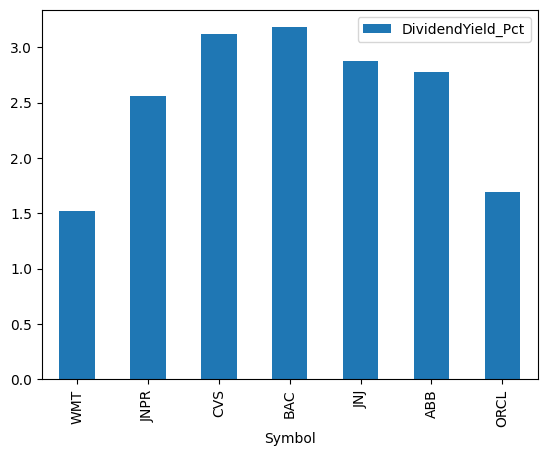

In [31]:
print(fundametals["DividendYield_Pct"].describe())
fundametals[["Symbol","DividendYield_Pct"]].plot(kind="bar",x="Symbol")

In [48]:
#now let's try to create our ratios

#1. BETA we can get it from the table above
fundametals['Beta'] = fundametals['Beta'].astype('float')
fundametals['Beta'].describe()

#2. Dividend Yield % we just calculated
print("% Yield\n",fundametals['DividendYield_Pct'].describe())

#3. Dividend Payout Ratio
# We'll get this by saying 1-Retention Ratio = 1-((EPS-DPS)/EPS)
fundametals['DPR'] = 1- (fundametals['EPS'] - fundametals['DividendPerShare']) / fundametals['EPS']
print("DPR\n",fundametals['DPR'].describe())

% Yield
 count    7.000000
mean     2.532857
std      0.668598
min      1.520000
25%      2.125000
50%      2.780000
75%      3.000000
max      3.180000
Name: DividendYield_Pct, dtype: float64
DPR
 count    7.000000
mean     0.554470
std      0.156468
min      0.267913
25%      0.486472
50%      0.587413
75%      0.674058
max      0.704902
Name: DPR, dtype: float64


In [51]:

fundametals[['Symbol','DPR']]

,Symbol,DPR
1,WMT,0.524099
2,JNPR,0.587413
3,CVS,0.704902
4,BAC,0.267913
5,JNJ,0.660237
6,ABB,0.687879
7,ORCL,0.448845


1    0.524099
2    0.587413
3    0.704902
4    0.267913
5    0.660237
6    0.687879
7    0.448845
dtype: float64